In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [19]:
%load_ext autoreload
%autoreload 2
import cProfile
from datetime import datetime
import importlib
import numpy as np
import os
import shutil
import yaml
from rdkit import RDLogger
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

def execute_yaml(yaml_path: str) -> MCTS:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    logger = make_logger(output_dir)

    transition_conf = conf.get("transition_conf", {})
    if "model_dir" in transition_conf:
        transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
        lang_path = add_sep(transition_conf["model_dir"]) + lang_name
    lang = Language.load(lang_path, device=conf.get("device"))
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, **transition_conf)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_conf", {}))
    policy_class = class_from_package("policy", conf.get("policy_class"))
    policy = policy_class(**conf.get("policy_conf", {}))

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization
    generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **conf.get("generator_conf", {}))

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)

    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    # cProfile.run("generator.generate(root=root, **generation_conf)"")
    generator.plot(**conf.get("plot_conf", {}))
    generator.analyze()
    
    return generator, conf

def queue_yaml(*args: str):
    for yaml_path in args:
        execute_yaml(yaml_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Is CUDA available: True
Starting generation...
1- time: 0.00, reward: 0.922778860901891, node: PEPTIDE1{[ac].I.I.G.G.Q.L.Q.S.G.L.Q.[am]}$$$$
2- time: 0.00, reward: -0.9312009723684448, node: PEPTIDE1{E.E.I.K.T.E.H.R.M.D.A.E.F.R.W.A.R.H}$$$$
3- time: 0.21, reward: -0.9340024335142174, node: PEPTIDE1{A.R.Y.Y.S.A.L.R.H.Y.I.N.L.I.T.R.Q.R.Y.[am]}$$$$
4- time: 0.21, reward: -0.9446596500574793, node: PEPTIDE1{S.L.V.E.P.L.S.I.Y.S.L.R.R.N.H.A.E.N.L.F.T.R.H.Y.[am]}$$$$
5- time: 0.21, reward: -0.8379285079146236, node: PEPTIDE1{R.[dW].[dF].I.[dF].H.K.R.W.[am]}$$$$
6- time: 0.47, reward: -0.9272017437597972, node: PEPTIDE1{[ac].F.Q.S.K.E.N.V.F.V.D.G.Y.F.E.R.L.[dC].A.K.L.[am]}$$$$
7- time: 0.47, reward: -0.7702912771786258, node: PEPTIDE1{[ac].H.F.R.W.V.[am]}$$$$
8- time: 0.47, reward: -0.8104757020357558, node: PEPTIDE1{[ac].P.S.[dK].[dP].P.I.[dF].[am]}$$$$
9- time: 0.63, reward: -0.9533993435011789, node: PEPTIDE1{Y.P.S.K.[dD].A.I.P.G.E.D.A.P.A.E.D.L.A.R.Y.Y.S.A.L.R.H.Y.I.N.L.I.T.R.A.R.Y.[am]}$$

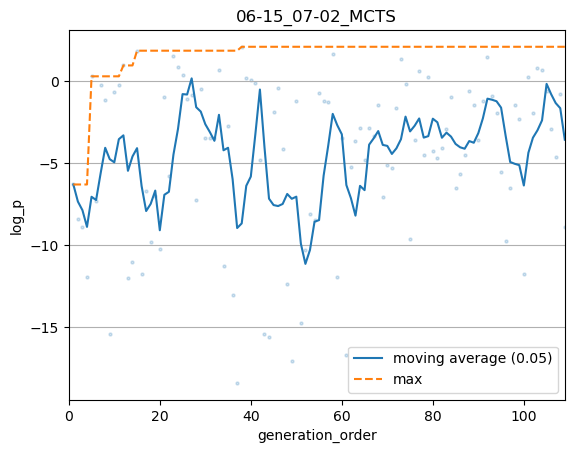

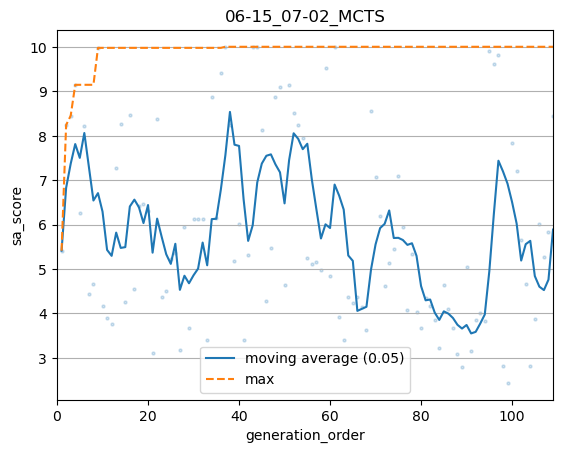

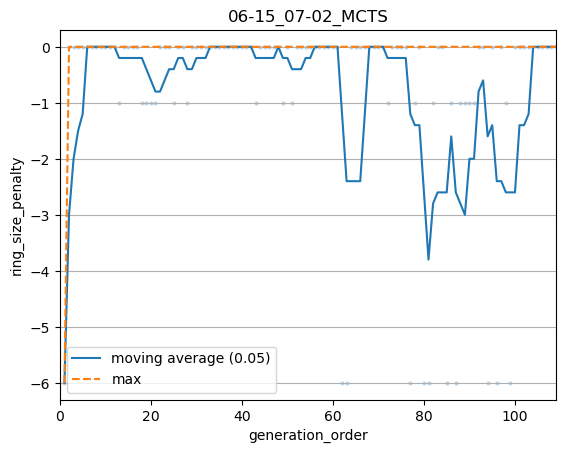

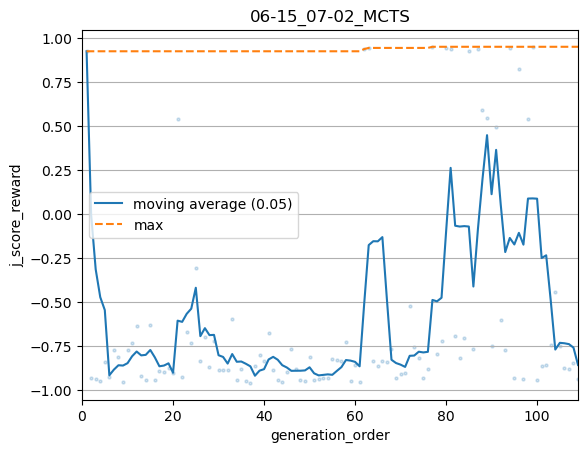

number of generated nodes: 109
valid rate: 0.717948717948718
unique rate: 0.9807692307692307
node_per_sec: 10.652269633457594


In [20]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
generator, conf = execute_yaml(c2)
# queue_yaml(c1, c2)

Starting generation...
105- time: 10.11, reward: -0.8510277950449067, node: PEPTIDE1{[dA].C.H.A.G.A.N.M.L.[dP].V.T.[am]}$$$$
106- time: 10.11, reward: -0.9159794790283979, node: PEPTIDE1{[dA].C.G.A.Q.R.T.V.T.L.Y.L.H.G}$$$$
107- time: 10.32, reward: -0.8701007464953046, node: PEPTIDE1{[dA].K.[dR].A.K.L.F.K.R}$$$$
108- time: 10.32, reward: -0.858204327876979, node: PEPTIDE1{[dA].K.A.Q.V.P.F.S.V}$$$$
109- time: 10.49, reward: -0.7658825400987919, node: PEPTIDE1{[ac].Y.G.L.R.[am]}$$$$
110- time: 10.49, reward: -0.9484947387377612, node: PEPTIDE1{[ac].Y.T.S.L.I.D.E.L.I.K.K.S.E.E.Q.Q.Q.K.N.Q.E.E.L.K.K.L.F.E.W.A.K.K.W.N.W.F.[am]}$$$$
111- time: 10.49, reward: -0.9083869252645005, node: PEPTIDE1{[ac].Y.S.L.R.H.Y.L.N.[dF].R.V.V.T.[am]}$$$$
112- time: 10.74, reward: 0.9445664715472193, node: PEPTIDE1{[dA].D.A.V.[am]}$$$$
113- time: 10.74, reward: 0.9234958088457837, node: PEPTIDE1{[dA].D.S.N.G.D.R}$$$$
114- time: 10.74, reward: 0.9443877809600203, node: PEPTIDE1{[dA].D.G.K}$$$$
115- time: 10.80,

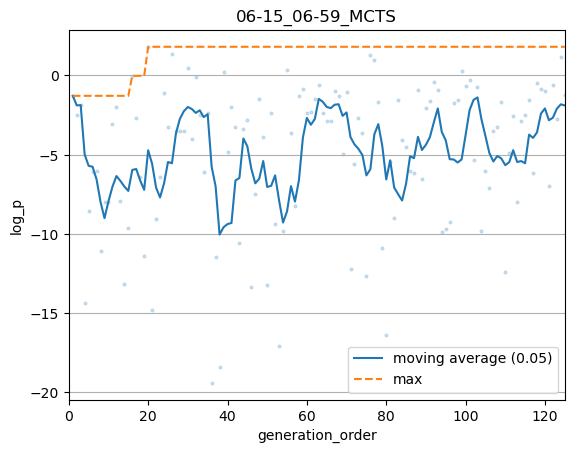

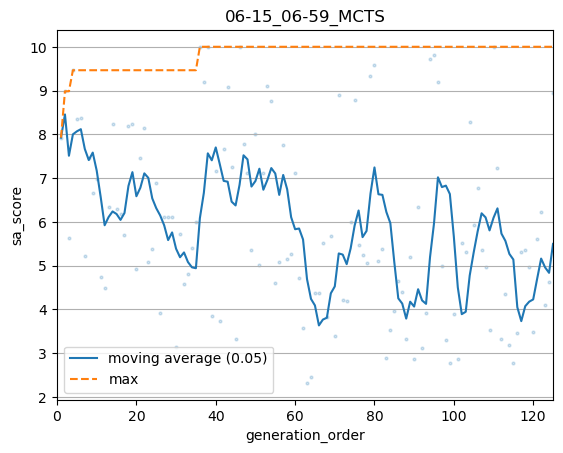

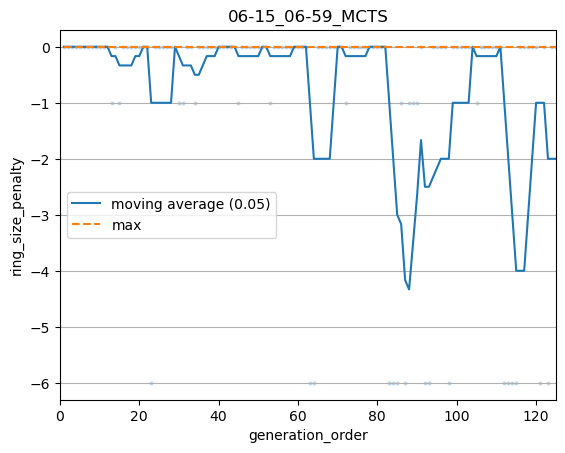

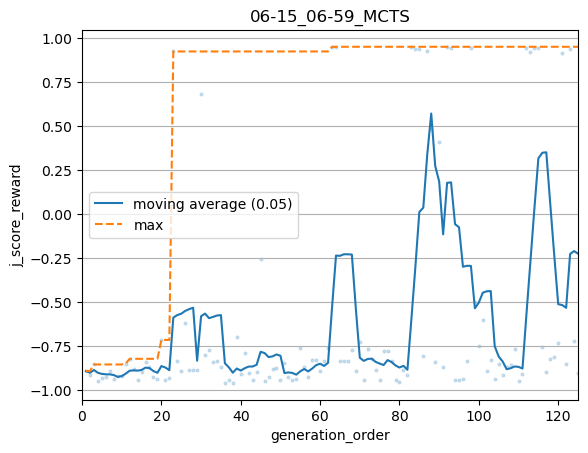

number of generated nodes: 125
valid rate: 0.7175141242937852
unique rate: 0.9887005649717514
node_per_sec: 11.081776505022338


In [18]:
#continue search
generator.generate(max_generations=20)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [14]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [17]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook